# ВНИМАНИЕ!!! 

В оригинале этот код запускался в google colab, чтобы запустить этот ноутбук, укажите ваш путь к train_dataset_rzhd_model_train.rar

# Загрузка данных из Архива

In [1]:
!pip install patool

from google.colab import drive
import patoolib
import pandas as pd
import glob
import zipfile
import os
from tqdm import tqdm

drive.mount('/content/drive')

rar_path = '/content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar'

output_folder = '/content/unzipped_folder'
os.makedirs(output_folder, exist_ok=True)
patoolib.extract_archive(rar_path, outdir='/content')


output_folder = '/content/unzipped_folder'

# Путь к папке с файлами
file_path = '/content/РЖД train/Выгрузка_маркетинговые списки/*.xls'

# Список всех файлов
all_files = glob.glob(file_path)

# Создание списка DataFrame для каждого файла
df_list = []

for file in all_files:
    # Чтение файла
    df = pd.read_excel(file)

    # Извлечение области из имени файла
    region = file.split('_')[-1].split('.')[0]  # Например, "Владимирская область"

    # Добавление столбца с регионом
    df['Регион'] = region

    # Добавление в список
    df_list.append(df)

# Объединение всех DataFrame в один
df_mc = pd.concat(df_list, ignore_index=True)

df_raw = pd.read_excel('/content/РЖД train/Выгрузки_интересы+обращения+объёмы перевозок/Объёмы перевозок.xls', skiprows=1)

list_vol = list()
list_price = list()
unnamed_list = ['Unnamed: 0',	'Unnamed: 1',	'Unnamed: 2', 	'Unnamed: 3', 'Месяц']
for col in df_raw.columns:
  if col not in unnamed_list:
    if '.1' in col:
      list_vol.append(col)
    else:
      list_price.append(col)

df_vol = df_raw[unnamed_list + list_vol]
df_price = df_raw[unnamed_list + list_price]

df_vol.rename(columns={'Unnamed: 0': 'ID',
                       'Unnamed: 1': 'Субъект федерации отп',
                       'Unnamed: 2': 'Субъект федерации наз',
                       'Unnamed: 3': 'Код груза',
                       'Месяц': 'Гр груза по опер.номен'}, inplace=True)
df_price.rename(columns={'Unnamed: 0': 'ID',
                       'Unnamed: 1': 'Субъект федерации отп',
                       'Unnamed: 2': 'Субъект федерации наз',
                       'Unnamed: 3': 'Код груза',
                       'Месяц': 'Гр груза по опер.номен' }, inplace=True)

df_vol = df_vol.iloc[1:]
df_price = df_price.iloc[1:]
df_vol.columns = df_vol.columns.str.replace('.1$', '', regex=True)


df_req = pd.read_excel('/content/РЖД train/Выгрузки_интересы+обращения+объёмы перевозок/Обращения.xls')

df_interest = pd.read_excel('/content/РЖД train/Выгрузки_интересы+обращения+объёмы перевозок/Интересы.xls')

date_columns = [col for col in df_price.columns if '/' in col]
date_columns = pd.to_datetime(date_columns, format='%Y/%m')
sorted_date_columns = sorted(date_columns)

# Обновление DataFrame с новыми отсортированными столбцами
sorted_columns = df_price.columns.tolist()
sorted_columns = [col for col in sorted_columns if col not in date_columns]
sorted_columns += [d.strftime('%Y/%m') for d in sorted_date_columns]

# Обновляем DataFrame
df_price = df_price.reindex(columns=sorted_columns)


date_columns = [col for col in df_vol.columns if '/' in col]
date_columns = pd.to_datetime(date_columns, format='%Y/%m')
sorted_date_columns = sorted(date_columns)

# Обновление DataFrame с новыми отсортированными столбцами
sorted_columns = df_vol.columns.tolist()
sorted_columns = [col for col in sorted_columns if col not in date_columns]
sorted_columns += [d.strftime('%Y/%m') for d in sorted_date_columns]

# Обновляем DataFrame
df_vol = df_vol.reindex(columns=sorted_columns)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 6.8 MB/s eta 0:00:00
Mounted at /content/drive


INFO patool: Extracting /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar ...
INFO:patool:Extracting /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar ...
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar
INFO patool:     with cwd='/content', input=''
INFO:patool:    with cwd='/content', input=''
INFO patool: ... /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar extracted to `/content'.
INFO:patool:... /content/drive/MyDrive/digital/train_dataset_rzhd_model_train.rar extracted to `/content'.
<ipython-input-1-01dc1ecdf866>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol.rename(columns={'

In [ ]:
df_interest['Дата'] = pd.to_datetime(df_interest['Дата'], format='%d.%m.%Y %H:%M')

# Создаем датасет для обучения моделей

In [82]:
agg_funcs = {
    'Субъект федерации отп': lambda x: x.mode()[0],  # Мода
    'Субъект федерации наз': lambda x: x.mode()[0],  # Мода
    'Код груза': lambda x: x.mode()[0],  # Мода
    'Гр груза по опер.номен': lambda x: x.mode()[0]  # Мода
}

# Добавляем сумму для всех остальных столбцов
for col in df_price.columns[5:]:  # Пропускаем первые 5 столбцов
    agg_funcs[col] = 'sum'

# Создаем новый DataFrame с агрегированными данными
df_targets = df_price.groupby('ID').agg(agg_funcs).reset_index()

Просто создаю списки колонок для разных целей

In [83]:
date_cols = ['2022/01', '2022/02', '2022/03', '2022/04',
       '2022/05', '2022/06', '2022/07', '2022/08', '2022/09', '2022/10',
       '2022/11', '2022/12', '2023/01', '2023/02', '2023/03', '2023/04',
       '2023/05', '2023/06', '2023/07', '2023/08', '2023/09', '2023/10',
       '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04',
       '2024/05', '2024/06', '2024/07', '2024/08']
last_6_cols = ['2024/03', '2024/04',
       '2024/05', '2024/06', '2024/07', '2024/08']
last_12_cols = ['2023/09', '2023/10',
       '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04',
       '2024/05', '2024/06', '2024/07', '2024/08']
last_18_cols = ['2023/03', '2023/04',
       '2023/05', '2023/06', '2023/07', '2023/08', '2023/09', '2023/10',
       '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04',
       '2024/05', '2024/06', '2024/07', '2024/08']

cols_train2 = [ '2023/03', '2023/04',
       '2023/05', '2023/06', '2023/07', '2023/08']

cols_for_train1 = ['2023/03', '2023/04','2023/05', '2023/06', '2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02']
cols_for_train2 = ['2022/03', '2022/04',
       '2022/05', '2022/06', '2022/07', '2022/08', '2022/09', '2022/10',
       '2022/11', '2022/12', '2023/01', '2023/02']

cols_for_now = ['2023/09', '2023/10',
       '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04',
       '2024/05', '2024/06', '2024/07', '2024/08']

Создаю значения таргета. Таргет - на следующие 6 месяцев от момента рассмотрения не было закупок, то есть предполагаем,что клиент ушел

Далее создаю 2 датасета. 1 - смотрим на момент 01.02.2024 и будем предсказывать будут ли закупки в следующие 6 месяцев (0) или нет (1) то есть, предполагаем, что ушел.

2 датасет - смотрим на момент 01.02.2023 аналогично

In [197]:
df_targets['target1'] = (df_targets[last_6_cols].sum(axis=1) == 0).astype(int)
df_targets['target2'] = (df_targets[cols_train2].sum(axis=1) == 0).astype(int)

df_train1 = df_targets[['ID', 'target1']]
df_train2 = df_targets[['ID', 'target2']]

Далее для разметки нашего датасета текущего берем только тех, кто еще не ушел и запишем в датасет df3

In [215]:
mask = (df_targets[last_6_cols] != 0).any(axis=1)

# Filter df3 based on the mask
df3 = df_targets[mask].copy()[['ID']]

Далее создаем новые признаки для каждого ID и без ликов данных. Подробнее признаки будут в презентации указаны.

In [182]:
for index, row in tqdm(df_train1.iterrows()):
  id = row['ID']
  price_info = df_price[df_price.ID == id]
  vol_info = df_vol[df_vol.ID == id]
  reg1_mode = price_info['Субъект федерации отп'].mode()
  reg1_count = len(price_info['Субъект федерации отп'].unique())
  reg2_mode = price_info['Субъект федерации наз'].mode()
  reg2_count = len(price_info['Субъект федерации наз'].unique())
  code_mode = price_info['Код груза'].mode()
  name_mode = price_info['Гр груза по опер.номен'].mode()
  code_count = len(price_info['Код груза'].unique())
  name_count = len(price_info['Гр груза по опер.номен'].unique())
  # prices = price_info[cols_for_train1].values.flatten()
  # vols = vol_info[cols_for_train1].values.flatten()
  df_train1.loc[index, 'reg1_mode'] = reg1_mode[0] if not reg1_mode.empty else None
  df_train1.loc[index, 'reg1_count'] = reg1_count
  df_train1.loc[index, 'reg2_mode'] = reg2_mode[0] if not reg2_mode.empty else None
  df_train1.loc[index, 'reg2_count'] = reg2_count
  df_train1.loc[index, 'code_mode'] = code_mode[0] if not code_mode.empty else None
  df_train1.loc[index, 'code_count'] = code_count
  df_train1.loc[index, 'name_mode'] = name_mode[0] if not name_mode.empty else None
  df_train1.loc[index, 'name_count'] = name_count
  for col in cols_for_train1:
    df_train1.loc[index, f'{col}_sum_price'] = price_info[col].sum()
    df_train1.loc[index, f'{col}_count_price'] = price_info[col].notnull().sum()
  for col in cols_for_train1:
    df_train1.loc[index, f'{col}_sum_vol'] = vol_info[col].sum()
    df_train1.loc[index, f'{col}_count_vol'] = vol_info[col].notnull().sum()

  req = df_req[df_req['ID'] == id]
  req_count = len(req)
  df_train1.loc[index, 'req_count'] = req_count

  req_mode = req['Тема вопроса'].mode()
  req_count_uniq = len(req['Тема вопроса'].unique())
  df_train1.loc[index, 'req_mode'] = req_mode[0] if not req_mode.empty else 'Нет'
  df_train1.loc[index, 'req_count_uniq'] = req_count_uniq

  req_group_mode = req['Группа вопросов'].mode()
  req_group_count_uniq = len(req['Группа вопросов'].unique())
  df_train1.loc[index, 'req_group_mode'] = req_group_mode[0] if not req_group_mode.empty else 'Нет'
  df_train1.loc[index, 'req_group_count_uniq'] = req_group_count_uniq


  interest = df_interest[(df_interest['ID'] == id)&(df_interest['Дата'] < pd.to_datetime('01.02.2024'))]
  interest_count = len(interest)
  df_train1.loc[index, 'interest_count'] = interest_count
  interest_count_uniq_scen = len(interest['Сценарий'].unique())
  df_train1.loc[index, 'interest_count_uniq_scen'] = interest_count_uniq_scen

  interest_count_uniq_ch = len(interest['Канал первичного интереса'].unique())
  df_train1.loc[index, 'interest_count_uniq_ch'] = interest_count_uniq_ch

  interest_mode_ch = interest['Канал первичного интереса'].mode()
  df_train1.loc[index, 'interest_mode_ch'] = interest_mode_ch[0] if not interest_mode_ch.empty else 'Нет'

  interest_mode_scen = interest['Сценарий'].mode()
  df_train1.loc[index, 'interest_mode_scen'] = interest_mode_scen[0] if not interest_mode_scen.empty else 'Нет'

  interest_mode_state = interest['Состояние'].mode()
  df_train1.loc[index, 'interest_mode_state'] = interest_mode_state[0] if not interest_mode_state.empty else 'Нет'

  interest_count_bad = len(interest[interest['Состояние'] == 'Завершен неудачно'])
  df_train1.loc[index, 'interest_count_bad'] = interest_count_bad

  interest_count_good = len(interest[interest['Состояние'] == 'Завершен успешно'])
  df_train1.loc[index, 'interest_count_good'] = interest_count_good

  mc = df_mc[df_mc['ID'] == id]
  mc_count = len(mc)
  df_train1.loc[index, 'mc_count'] = mc_count

  mc_msp_mode = mc['Находится в реестре МСП'].mode()
  df_train1.loc[index, 'mc_msp_mode'] = mc_msp_mode[0] if not mc_msp_mode.empty else 'unknown'

  mc_size_mode = mc['Размер компании.Наименование'].mode()
  df_train1.loc[index, 'mc_size_mode'] = mc_size_mode[0] if not mc_size_mode.empty else 'unknown'

  mc_okved_mode = mc['ОКВЭД2.Код'].mode()
  df_train1.loc[index, 'mc_okved_mode'] = mc_okved_mode[0] if not mc_okved_mode.empty and not mc_okved_mode.isnull().any() else 'unknown'

# Регион
  mc_region_mode = mc['Регион'].mode()
  df_train1.loc[index, 'mc_region_mode'] = mc_region_mode[0] if not mc_region_mode.empty else 'unknown'

# Грузоотправитель
  mc_sender_mode = mc['Грузоотправитель'].mode()
  df_train1.loc[index, 'mc_sender_mode'] = mc_sender_mode[0] if not mc_sender_mode.empty else 'unknown'

# Грузополучатель
  mc_receiver_mode = mc['Грузополучатель'].mode()
  df_train1.loc[index, 'mc_receiver_mode'] = mc_receiver_mode[0] if not mc_receiver_mode.empty else 'unknown'

0it [00:00, ?it/s]<ipython-input-182-140c9b447627>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train1.loc[index, 'reg1_mode'] = reg1_mode[0] if not reg1_mode.empty else None
<ipython-input-182-140c9b447627>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train1.loc[index, 'reg1_count'] = reg1_count
<ipython-input-182-140c9b447627>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [183]:
for index, row in tqdm(df_train2.iterrows()):
    id = row['ID']
    price_info = df_price[df_price.ID == id]
    vol_info = df_vol[df_vol.ID == id]

    # Регион 1
    reg1_mode = price_info['Субъект федерации отп'].mode()
    reg1_count = len(price_info['Субъект федерации отп'].unique())

    # Регион 2
    reg2_mode = price_info['Субъект федерации наз'].mode()
    reg2_count = len(price_info['Субъект федерации наз'].unique())

    # Код груза
    code_mode = price_info['Код груза'].mode()
    code_count = len(price_info['Код груза'].unique())

    # Название груза
    name_mode = price_info['Гр груза по опер.номен'].mode()
    name_count = len(price_info['Гр груза по опер.номен'].unique())

    # Заполнение df_train2
    df_train2.loc[index, 'reg1_mode'] = reg1_mode[0] if not reg1_mode.empty else None
    df_train2.loc[index, 'reg1_count'] = reg1_count
    df_train2.loc[index, 'reg2_mode'] = reg2_mode[0] if not reg2_mode.empty else None
    df_train2.loc[index, 'reg2_count'] = reg2_count
    df_train2.loc[index, 'code_mode'] = code_mode[0] if not code_mode.empty else None
    df_train2.loc[index, 'code_count'] = code_count
    df_train2.loc[index, 'name_mode'] = name_mode[0] if not name_mode.empty else None
    df_train2.loc[index, 'name_count'] = name_count

    # Обработка цен и объемов
    for col in cols_for_train2:
        df_train2.loc[index, f'{col}_sum_price'] = price_info[col].sum()
        df_train2.loc[index, f'{col}_count_price'] = price_info[col].notnull().sum()

    for col in cols_for_train2:
        df_train2.loc[index, f'{col}_sum_vol'] = vol_info[col].sum()
        df_train2.loc[index, f'{col}_count_vol'] = vol_info[col].notnull().sum()

    # Обработка запросов
    req = df_req[df_req['ID'] == id]
    req_count = len(req)
    df_train2.loc[index, 'req_count'] = req_count

    req_mode = req['Тема вопроса'].mode()
    req_count_uniq = len(req['Тема вопроса'].unique())
    df_train2.loc[index, 'req_mode'] = req_mode[0] if not req_mode.empty else 'Нет'
    df_train2.loc[index, 'req_count_uniq'] = req_count_uniq

    req_group_mode = req['Группа вопросов'].mode()
    req_group_count_uniq = len(req['Группа вопросов'].unique())
    df_train2.loc[index, 'req_group_mode'] = req_group_mode[0] if not req_group_mode.empty else 'Нет'
    df_train2.loc[index, 'req_group_count_uniq'] = req_group_count_uniq

    # Обработка интересов
    interest = df_interest[(df_interest['ID'] == id) & (df_interest['Дата'] < pd.to_datetime('01.02.2023'))]
    interest_count = len(interest)
    df_train2.loc[index, 'interest_count'] = interest_count
    interest_count_uniq_scen = len(interest['Сценарий'].unique())
    df_train2.loc[index, 'interest_count_uniq_scen'] = interest_count_uniq_scen

    interest_count_uniq_ch = len(interest['Канал первичного интереса'].unique())
    df_train2.loc[index, 'interest_count_uniq_ch'] = interest_count_uniq_ch

    interest_mode_ch = interest['Канал первичного интереса'].mode()
    df_train2.loc[index, 'interest_mode_ch'] = interest_mode_ch[0] if not interest_mode_ch.empty else 'Нет'

    interest_mode_scen = interest['Сценарий'].mode()
    df_train2.loc[index, 'interest_mode_scen'] = interest_mode_scen[0] if not interest_mode_scen.empty else 'Нет'

    interest_mode_state = interest['Состояние'].mode()
    df_train2.loc[index, 'interest_mode_state'] = interest_mode_state[0] if not interest_mode_state.empty else 'Нет'

    interest_count_bad = len(interest[interest['Состояние'] == 'Завершен неудачно'])
    df_train2.loc[index, 'interest_count_bad'] = interest_count_bad

    interest_count_good = len(interest[interest['Состояние'] == 'Завершен успешно'])
    df_train2.loc[index, 'interest_count_good'] = interest_count_good

    # Обработка МСП
    mc = df_mc[df_mc['ID'] == id]
    mc_count = len(mc)
    df_train2.loc[index, 'mc_count'] = mc_count

    mc_msp_mode = mc['Находится в реестре МСП'].mode()
    df_train2.loc[index, 'mc_msp_mode'] = mc_msp_mode[0] if not mc_msp_mode.empty else 'unknown'

    mc_size_mode = mc['Размер компании.Наименование'].mode()
    df_train2.loc[index, 'mc_size_mode'] = mc_size_mode[0] if not mc_size_mode.empty else 'unknown'

    mc_okved_mode = mc['ОКВЭД2.Код'].mode()
    df_train2.loc[index, 'mc_okved_mode'] = mc_okved_mode[0] if not mc_okved_mode.empty and not mc_okved_mode.isnull().any() else 'unknown'

    # Регион
    mc_region_mode = mc['Регион'].mode()
    df_train2.loc[index, 'mc_region_mode'] = mc_region_mode[0] if not mc_region_mode.empty else 'unknown'

    # Грузоотправитель
    mc_sender_mode = mc['Грузоотправитель'].mode()
    df_train2.loc[index, 'mc_sender_mode'] = mc_sender_mode[0] if not mc_sender_mode.empty else 'unknown'

    # Грузополучатель
    mc_receiver_mode = mc['Грузополучатель'].mode()
    df_train2.loc[index, 'mc_receiver_mode'] = mc_receiver_mode[0] if not mc_receiver_mode.empty else 'unknown'

0it [00:00, ?it/s]<ipython-input-183-c72340925ba6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2.loc[index, 'reg1_mode'] = reg1_mode[0] if not reg1_mode.empty else None
<ipython-input-183-c72340925ba6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2.loc[index, 'reg1_count'] = reg1_count
<ipython-input-183-c72340925ba6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [184]:
df_train1

,ID,target1,reg1_mode,reg1_count,reg2_mode,reg2_count,code_mode,code_count,name_mode,name_count,...,interest_mode_state,interest_count_bad,interest_count_good,mc_count,mc_msp_mode,mc_size_mode,mc_okved_mode,mc_region_mode,mc_sender_mode,mc_receiver_mode
0,9,0,Владимирская область,1.0,Иркутская область,1.0,30306.0,1.0,ОГНЕУПОРЫ,1.0,...,Нет,0.0,0.0,6.0,Нет,Микробизнес,52.10,Владимирская область,Да,Да
1,25,0,Владимирская область,1.0,Челябинская область,11.0,29101.0,2.0,ФЛЮСЫ,2.0,...,Коммерческое предложение,0.0,0.0,42.0,Нет,Средний бизнес,08.11.2,Владимирская область,Да,Да
2,33,0,Владимирская область,1.0,Субъект РФ не определен,61.0,41416.0,4.0,МЕТИЗЫ,3.0,...,Завершен неудачно,4.0,0.0,24.0,Нет,Крупный бизнес,30.20.4,Владимирская область,Да,Да
3,86,1,Нижегородская область,1.0,Брянская область,1.0,31607.0,1.0,ЛОМ ЧЕРНЫХ МЕТАЛЛОВ,1.0,...,Завершен неудачно,3.0,1.0,1.0,Нет,unknown,unknown,Владимирская область,Да,Да
4,115,0,Владимирская область,1.0,Астраханская область,35.0,12203.0,4.0,ЛЕСНЫЕ ГРУЗЫ,1.0,...,Завершен неудачно,8.0,0.0,14.0,Нет,Крупный бизнес,16.21.1,Владимирская область,Да,Да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,21725,0,Владимирская область,1.0,Нижегородская область,1.0,39146.0,1.0,МЕТИЗЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
952,21726,0,Владимирская область,1.0,Красноярский край,1.0,58111.0,1.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
953,21727,0,Чувашская Республика-Чаваш Республики,1.0,Приморский край,1.0,55620.0,2.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
954,21728,0,Удмуртская Республика,1.0,Ставропольский край,1.0,39146.0,1.0,МЕТИЗЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown


In [187]:
df_train2

,ID,target1,reg1_mode,reg1_count,reg2_mode,reg2_count,code_mode,code_count,name_mode,name_count,...,interest_mode_state,interest_count_bad,interest_count_good,mc_count,mc_msp_mode,mc_size_mode,mc_okved_mode,mc_region_mode,mc_sender_mode,mc_receiver_mode
0,9,0,Владимирская область,1.0,Иркутская область,1.0,30306.0,1.0,ОГНЕУПОРЫ,1.0,...,Нет,0.0,0.0,6.0,Нет,Микробизнес,52.10,Владимирская область,Да,Да
1,25,0,Владимирская область,1.0,Челябинская область,11.0,29101.0,2.0,ФЛЮСЫ,2.0,...,Коммерческое предложение,0.0,0.0,42.0,Нет,Средний бизнес,08.11.2,Владимирская область,Да,Да
2,33,0,Владимирская область,1.0,Субъект РФ не определен,61.0,41416.0,4.0,МЕТИЗЫ,3.0,...,Завершен неудачно,1.0,0.0,24.0,Нет,Крупный бизнес,30.20.4,Владимирская область,Да,Да
3,86,0,Нижегородская область,1.0,Брянская область,1.0,31607.0,1.0,ЛОМ ЧЕРНЫХ МЕТАЛЛОВ,1.0,...,Завершен неудачно,2.0,0.0,1.0,Нет,unknown,unknown,Владимирская область,Да,Да
4,115,0,Владимирская область,1.0,Астраханская область,35.0,12203.0,4.0,ЛЕСНЫЕ ГРУЗЫ,1.0,...,Заключение договора,1.0,0.0,14.0,Нет,Крупный бизнес,16.21.1,Владимирская область,Да,Да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,21725,1,Владимирская область,1.0,Нижегородская область,1.0,39146.0,1.0,МЕТИЗЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
952,21726,1,Владимирская область,1.0,Красноярский край,1.0,58111.0,1.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
953,21727,1,Чувашская Республика-Чаваш Республики,1.0,Приморский край,1.0,55620.0,2.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
954,21728,1,Удмуртская Республика,1.0,Ставропольский край,1.0,39146.0,1.0,МЕТИЗЫ,1.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown


Для удобства конкатенирования датасетов сделаем одинаковые колонки (но будем помнить, что даты смещены на год)

In [186]:
df_train2.columns = df_train1.columns.copy()

Аналогично размечаем текущий датасет

In [217]:
for index, row in tqdm(df3.iterrows()):
    id = row['ID']
    price_info = df_price[df_price.ID == id]
    vol_info = df_vol[df_vol.ID == id]

    # Регион 1
    reg1_mode = price_info['Субъект федерации отп'].mode()
    reg1_count = len(price_info['Субъект федерации отп'].unique())

    # Регион 2
    reg2_mode = price_info['Субъект федерации наз'].mode()
    reg2_count = len(price_info['Субъект федерации наз'].unique())

    # Код груза
    code_mode = price_info['Код груза'].mode()
    code_count = len(price_info['Код груза'].unique())

    # Название груза
    name_mode = price_info['Гр груза по опер.номен'].mode()
    name_count = len(price_info['Гр груза по опер.номен'].unique())

    # Заполнение df3
    df3.loc[index, 'reg1_mode'] = reg1_mode[0] if not reg1_mode.empty else None
    df3.loc[index, 'reg1_count'] = reg1_count
    df3.loc[index, 'reg2_mode'] = reg2_mode[0] if not reg2_mode.empty else None
    df3.loc[index, 'reg2_count'] = reg2_count
    df3.loc[index, 'code_mode'] = code_mode[0] if not code_mode.empty else None
    df3.loc[index, 'code_count'] = code_count
    df3.loc[index, 'name_mode'] = name_mode[0] if not name_mode.empty else None
    df3.loc[index, 'name_count'] = name_count

    # Обработка цен и объемов
    for col in cols_for_now:
        df3.loc[index, f'{col}_sum_price'] = price_info[col].sum()
        df3.loc[index, f'{col}_count_price'] = price_info[col].notnull().sum()

    for col in cols_for_now:
        df3.loc[index, f'{col}_sum_vol'] = vol_info[col].sum()
        df3.loc[index, f'{col}_count_vol'] = vol_info[col].notnull().sum()

    # Обработка запросов
    req = df_req[df_req['ID'] == id]
    req_count = len(req)
    df3.loc[index, 'req_count'] = req_count

    req_mode = req['Тема вопроса'].mode()
    req_count_uniq = len(req['Тема вопроса'].unique())
    df3.loc[index, 'req_mode'] = req_mode[0] if not req_mode.empty else 'Нет'
    df3.loc[index, 'req_count_uniq'] = req_count_uniq

    req_group_mode = req['Группа вопросов'].mode()
    req_group_count_uniq = len(req['Группа вопросов'].unique())
    df3.loc[index, 'req_group_mode'] = req_group_mode[0] if not req_group_mode.empty else 'Нет'
    df3.loc[index, 'req_group_count_uniq'] = req_group_count_uniq

    # Обработка интересов (без ограничения по дате)
    interest = df_interest[df_interest['ID'] == id]
    interest_count = len(interest)
    df3.loc[index, 'interest_count'] = interest_count
    interest_count_uniq_scen = len(interest['Сценарий'].unique())
    df3.loc[index, 'interest_count_uniq_scen'] = interest_count_uniq_scen

    interest_count_uniq_ch = len(interest['Канал первичного интереса'].unique())
    df3.loc[index, 'interest_count_uniq_ch'] = interest_count_uniq_ch

    interest_mode_ch = interest['Канал первичного интереса'].mode()
    df3.loc[index, 'interest_mode_ch'] = interest_mode_ch[0] if not interest_mode_ch.empty else 'Нет'

    interest_mode_scen = interest['Сценарий'].mode()
    df3.loc[index, 'interest_mode_scen'] = interest_mode_scen[0] if not interest_mode_scen.empty else 'Нет'

    interest_mode_state = interest['Состояние'].mode()
    df3.loc[index, 'interest_mode_state'] = interest_mode_state[0] if not interest_mode_state.empty else 'Нет'

    interest_count_bad = len(interest[interest['Состояние'] == 'Завершен неудачно'])
    df3.loc[index, 'interest_count_bad'] = interest_count_bad

    interest_count_good = len(interest[interest['Состояние'] == 'Завершен успешно'])
    df3.loc[index, 'interest_count_good'] = interest_count_good

    # Обработка МСП
    mc = df_mc[df_mc['ID'] == id]
    mc_count = len(mc)
    df3.loc[index, 'mc_count'] = mc_count

    mc_msp_mode = mc['Находится в реестре МСП'].mode()
    df3.loc[index, 'mc_msp_mode'] = mc_msp_mode[0] if not mc_msp_mode.empty else 'unknown'

    mc_size_mode = mc['Размер компании.Наименование'].mode()
    df3.loc[index, 'mc_size_mode'] = mc_size_mode[0] if not mc_size_mode.empty else 'unknown'

    mc_okved_mode = mc['ОКВЭД2.Код'].mode()
    df3.loc[index, 'mc_okved_mode'] = mc_okved_mode[0] if not mc_okved_mode.empty and not mc_okved_mode.isnull().any() else 'unknown'

    # Регион
    mc_region_mode = mc['Регион'].mode()
    df3.loc[index, 'mc_region_mode'] = mc_region_mode[0] if not mc_region_mode.empty else 'unknown'

    # Грузоотправитель
    mc_sender_mode = mc['Грузоотправитель'].mode()
    df3.loc[index, 'mc_sender_mode'] = mc_sender_mode[0] if not mc_sender_mode.empty else 'unknown'

    # Грузополучатель
    mc_receiver_mode = mc['Грузополучатель'].mode()
    df3.loc[index, 'mc_receiver_mode'] = mc_receiver_mode[0] if not mc_receiver_mode.empty else 'unknown'

610it [00:30, 20.12it/s]


In [218]:
df3

,ID,reg1_mode,reg1_count,reg2_mode,reg2_count,code_mode,code_count,name_mode,name_count,2023/09_sum_price,...,interest_mode_state,interest_count_bad,interest_count_good,mc_count,mc_msp_mode,mc_size_mode,mc_okved_mode,mc_region_mode,mc_sender_mode,mc_receiver_mode
0,9,Владимирская область,1.0,Иркутская область,1.0,30306.0,1.0,ОГНЕУПОРЫ,1.0,0.0,...,Нет,0.0,0.0,6.0,Нет,Микробизнес,52.10,Владимирская область,Да,Да
1,25,Владимирская область,1.0,Челябинская область,11.0,29101.0,2.0,ФЛЮСЫ,2.0,1640227.0,...,Коммерческое предложение,0.0,0.0,42.0,Нет,Средний бизнес,08.11.2,Владимирская область,Да,Да
2,33,Владимирская область,1.0,Субъект РФ не определен,61.0,41416.0,4.0,МЕТИЗЫ,3.0,12009393.0,...,Завершен неудачно,5.0,0.0,24.0,Нет,Крупный бизнес,30.20.4,Владимирская область,Да,Да
4,115,Владимирская область,1.0,Астраханская область,35.0,12203.0,4.0,ЛЕСНЫЕ ГРУЗЫ,1.0,11595996.0,...,Завершен неудачно,9.0,0.0,14.0,Нет,Крупный бизнес,16.21.1,Владимирская область,Да,Да
5,144,Владимирская область,2.0,Республика Коми,3.0,35129.0,1.0,"МАШИНЫ, СТАНКИ, ДВИГАТЕЛИ",1.0,0.0,...,Завершен неудачно,2.0,0.0,35.0,Нет,Крупный бизнес,27.12,Владимирская область,Да,Нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,21725,Владимирская область,1.0,Нижегородская область,1.0,39146.0,1.0,МЕТИЗЫ,1.0,0.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
952,21726,Владимирская область,1.0,Красноярский край,1.0,58111.0,1.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,0.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
953,21727,Чувашская Республика-Чаваш Республики,1.0,Приморский край,1.0,55620.0,2.0,ОСТАЛЬНЫЕ ПРОД. ТОВАРЫ,1.0,0.0,...,Коммерческое предложение,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown
954,21728,Удмуртская Республика,1.0,Ставропольский край,1.0,39146.0,1.0,МЕТИЗЫ,1.0,0.0,...,Нет,0.0,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown


In [219]:
df3.columns = df_train1.drop(columns = ['target1']).columns.copy()

# Обучаем модель


Разбиваем на трейн и тест (по ID)

In [188]:
unique_ids = pd.Series(df_train1['ID'].unique())

# Разбиваем на трейн и тест
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

test_df1 = df_train1[df_train1['ID'].isin(test_ids)]
test_df2 = df_train2[df_train2['ID'].isin(test_ids)]

# Объединяем тестовые данные
test = pd.concat([test_df1, test_df2], ignore_index=True)

# Получаем тренировочные данные
train_df1 = df_train1[df_train1['ID'].isin(train_ids)]
train_df2 = df_train2[df_train2['ID'].isin(train_ids)]


# Объединяем тренировочные данные
train = pd.concat([train_df1, train_df2], ignore_index=True)

In [28]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Отдельно выпишем категориальные признаки

In [259]:
cat_features = [
    'reg1_mode',
    'reg2_mode',
    'code_mode',
    'name_mode',
    'req_mode',
    'req_group_mode',
    'interest_mode_ch',
    'interest_mode_scen',
    'interest_mode_state',
    'mc_msp_mode',
    'mc_size_mode',
    'mc_okved_mode',
    'mc_region_mode',
    'mc_sender_mode',
    'mc_receiver_mode',
]


Была проблема в типах данных в датасетах, первые 4 строки исправляют ее

In [260]:
train[list(set(train.columns) - set(cat_features))] = train[list(set(train.columns) - set(cat_features))].astype(float)
train[cat_features] = train[cat_features].astype(str)
test[list(set(test.columns) - set(cat_features))] = test[list(set(test.columns) - set(cat_features))].astype(float)
test[cat_features] = test[cat_features].astype(str)

X_train = train.drop(columns=['ID', 'target1'])  # исключаем ID и target
y_train = train['target1']

X_test = test.drop(columns=['ID', 'target1'])  # исключаем ID и target
y_test = test['target1']

Далее просто обучаем катбуст

In [263]:
from sklearn.metrics import f1_score


model = CatBoostClassifier(cat_features=cat_features,
                           verbose=0)
model.fit(X_train, y_train)

# Предсказание и оценка точности на тестовой выборке
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # 'binary' для бинарной классификации, 'macro' или 'weighted' для многоклассовой

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7995
F1 Score: 0.7200


Получим еще вероятности предикта и посчитаем еще 2 показателя

In [262]:
from sklearn.metrics import roc_auc_score, log_loss

# Получение вероятностей для тестовой выборки
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятность класса 1

# Рассчитываем ROC-AUC и log loss
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_value = log_loss(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")


ROC-AUC: 0.8959
Log Loss: 0.3813


Далее посчитаем важность признаков и изобразим на графике

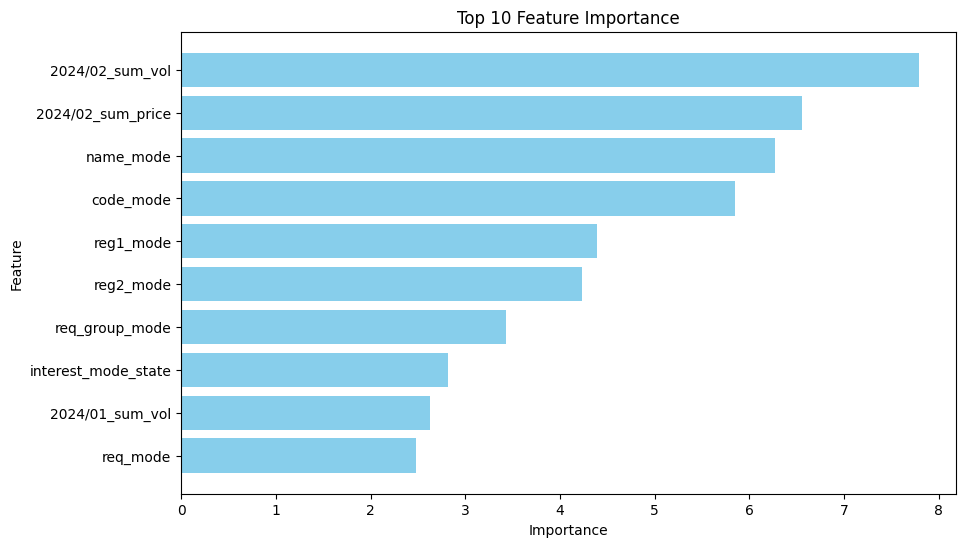

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Сортировка по важности признаков
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Вывод таблицы с топ-10 важностью признаков
top_features = feature_importance_df.head(10)

# Визуализация важности топ-10 признаков
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Чтобы наиболее важные признаки были сверху
plt.show()


Получим базовый предикт на текущий момент

In [223]:
df3[list(set(df3.columns) - set(cat_features))] = df3[list(set(df3.columns) - set(cat_features))].astype(float)
df3[cat_features] = df3[cat_features].astype(str)

In [267]:
df3[list(set(df3.columns) - set(cat_features))] = df3[list(set(df3.columns) - set(cat_features))].astype(float)
df3[cat_features] = df3[cat_features].astype(str)
pred_real = pd.DataFrame()
pred_real['ID'] = df3['ID']
pred_real['mc_region_mode'] = df3['mc_region_mode']
pred_real['prob'] = model.predict_proba(df3.drop(columns = 'ID'))[:, 1]
pred_real['ID'] = pred_real['ID'].astype(int).astype(str)

In [268]:
pred_real.sort_values(by = 'prob', ascending = False)

,ID,mc_region_mode,prob
656,16983,unknown,0.834996
739,20553,unknown,0.830322
406,12088,unknown,0.785140
483,12951,unknown,0.767086
651,16773,unknown,0.764627
...,...,...,...
292,10480,Республика Удмуртия,0.000958
377,11833,unknown,0.000887
87,2347,Кировская область,0.000878
566,14540,unknown,0.000846


In [270]:
pred_real.to_csv('for_streamlit.csv')

In [239]:
pd.set_option('display.max_columns', None)

# Отбор фичей для модели функция

Создадим функцию для проведения тестов и измерения качества от новых признаков

In [297]:
# фичи даты
date_cols_for_features = [ '2023/03_sum_price', '2023/03_count_price', '2023/04_sum_price',
       '2023/04_count_price', '2023/05_sum_price', '2023/05_count_price',
       '2023/06_sum_price', '2023/06_count_price', '2023/07_sum_price',
       '2023/07_count_price', '2023/08_sum_price', '2023/08_count_price',
       '2023/09_sum_price', '2023/09_count_price', '2023/10_sum_price',
       '2023/10_count_price', '2023/11_sum_price', '2023/11_count_price',
       '2023/12_sum_price', '2023/12_count_price', '2024/01_sum_price',
       '2024/01_count_price', '2024/02_sum_price', '2024/02_count_price',
       '2023/03_sum_vol', '2023/03_count_vol', '2023/04_sum_vol',
       '2023/04_count_vol', '2023/05_sum_vol', '2023/05_count_vol',
       '2023/06_sum_vol', '2023/06_count_vol', '2023/07_sum_vol',
       '2023/07_count_vol', '2023/08_sum_vol', '2023/08_count_vol',
       '2023/09_sum_vol', '2023/09_count_vol', '2023/10_sum_vol',
       '2023/10_count_vol', '2023/11_sum_vol', '2023/11_count_vol',
       '2023/12_sum_vol', '2023/12_count_vol', '2024/01_sum_vol',
       '2024/01_count_vol', '2024/02_sum_vol', '2024/02_count_vol']

Базовые признаки сделаем основанными на цене

In [300]:
base_cols = [x for x in date_cols_for_features if 'sum_price' in x]
other_data = list(set(date_cols_for_features) - set(base_cols))

Создадим еще датасет и будем записывать туда новые метрики

In [313]:
df_metrics = pd.DataFrame(columns=['Feature', 'acc', 'f1', 'roc_auc', 'log_loss'])

def feature_selection(train_df, test_df, features, cat_features , name):
    global df_metrics
    selected_features = features + base_cols + ['ID', 'target1']
    train_df = train_df[selected_features]
    test_df = test_df[selected_features]

    X_train = train_df.drop(columns=['ID', 'target1'])  # исключаем ID и target
    y_train = train_df['target1']

    X_test = test_df.drop(columns=['ID', 'target1'])  # исключаем ID и target
    y_test = test_df['target1']

    model = CatBoostClassifier(cat_features=cat_features,
                              verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятность класса 1

    # Рассчитываем ROC-AUC и log loss
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    log_loss_value = log_loss(y_test, y_pred_proba)

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Log Loss: {log_loss_value:.4f}")

    df_metrics = pd.concat([df_metrics, pd.DataFrame({'Feature': name, 'acc': accuracy, 'f1': f1, 'roc_auc': roc_auc, 'log_loss': log_loss_value}, index=[0])], ignore_index=True)

    feature_importance = model.get_feature_importance()
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top_features = feature_importance_df.head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 10 Feature Importance with {name}')
    plt.gca().invert_yaxis()
    plt.show()

    return


# Старт тестов

Пробуем группы признаков и сравниваем качество

Accuracy: 0.8021
F1 Score: 0.7467
ROC-AUC: 0.8676
Log Loss: 0.4085


<ipython-input-313-7b4c730a7c2d>:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



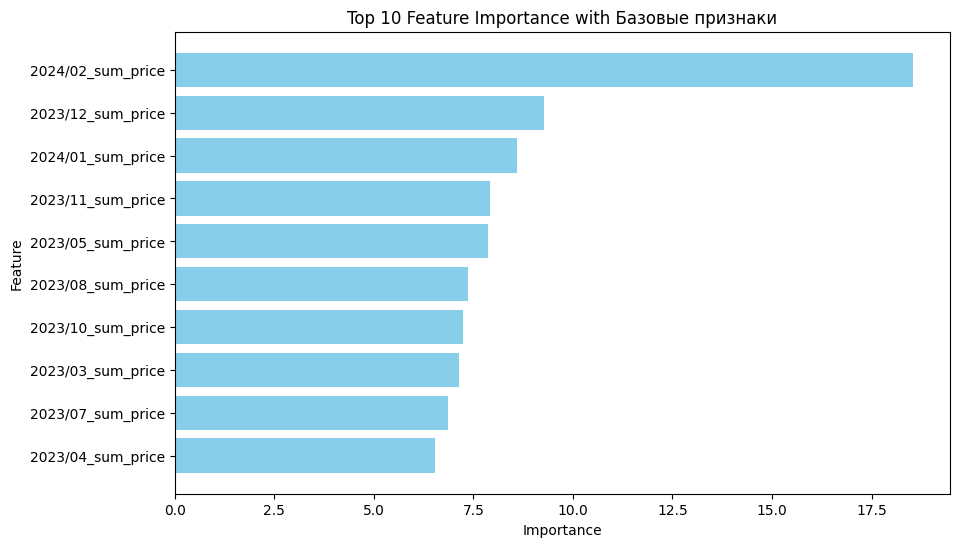

In [314]:
feature_selection(train_df = train, test_df = test, features = [],
                  cat_features = [],
                  name = 'Базовые признаки')

Accuracy: 0.7995
F1 Score: 0.7260
ROC-AUC: 0.8840
Log Loss: 0.3984


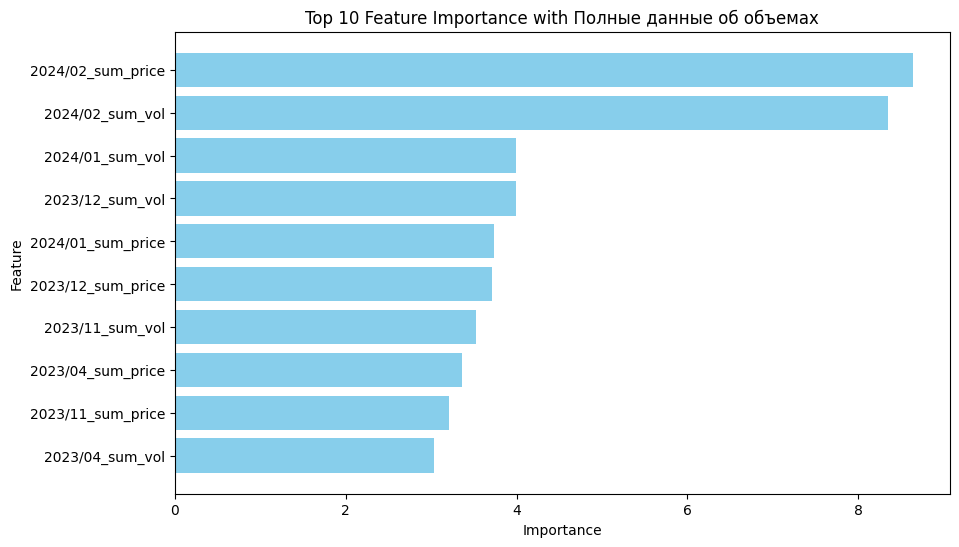

In [315]:
feature_selection(train_df = train, test_df = test, features = other_data,
                  cat_features = [],
                  name = 'Полные данные об объемах')

Accuracy: 0.8177
F1 Score: 0.7535
ROC-AUC: 0.8997
Log Loss: 0.3727


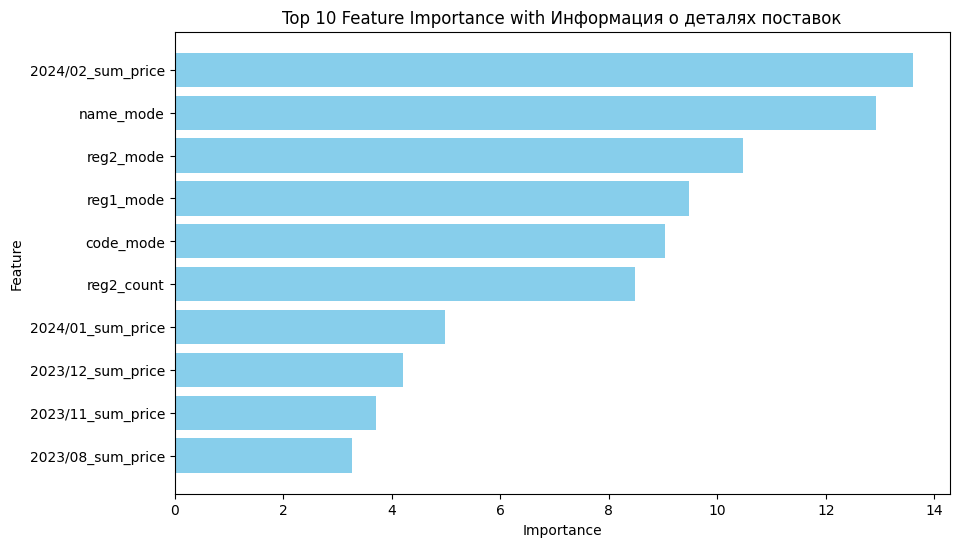

In [316]:
feature_selection(train_df = train, test_df = test, features = ['reg1_mode', 'reg1_count', 'reg2_mode', 'reg2_count', 'code_mode', 'code_count', 'name_mode', 'name_count'],
                  cat_features = ['reg1_mode','reg2_mode', 'code_mode', 'name_mode'],
                  name = 'Информация о деталях поставок')

Accuracy: 0.8021
F1 Score: 0.7450
ROC-AUC: 0.8786
Log Loss: 0.3980


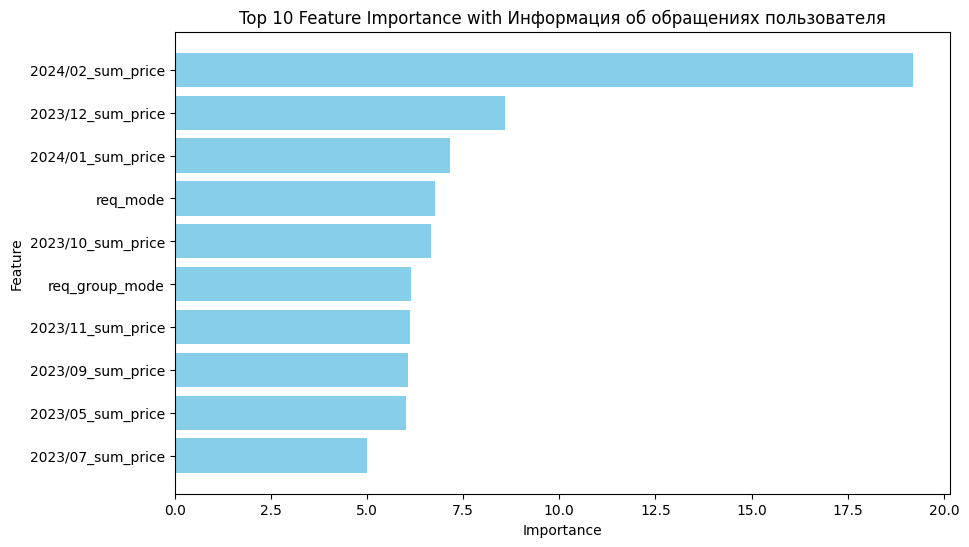

In [317]:
feature_selection(train_df = train, test_df = test, features = ['req_count', 'req_mode', 'req_count_uniq', 'req_group_mode','req_group_count_uniq'],
                  cat_features = ['req_mode','req_group_mode'],
                  name = 'Информация об обращениях пользователя')

Accuracy: 0.7969
F1 Score: 0.7417
ROC-AUC: 0.8752
Log Loss: 0.3977


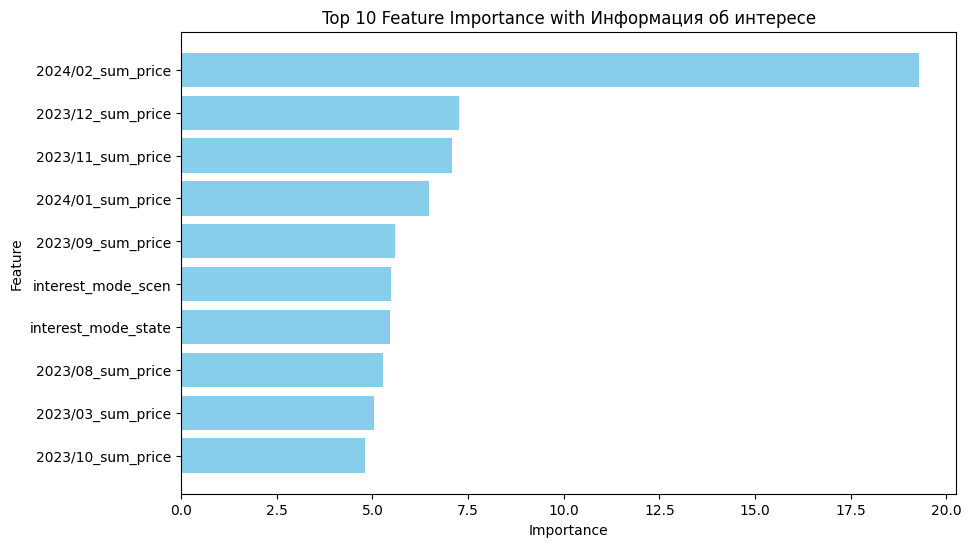

In [318]:
feature_selection(train_df = train, test_df = test, features = ['interest_count', 'interest_count_uniq_scen',
       'interest_count_uniq_ch', 'interest_mode_ch', 'interest_mode_scen',
       'interest_mode_state', 'interest_count_bad', 'interest_count_good'],
                  cat_features = ['interest_mode_ch', 'interest_mode_scen', 'interest_mode_state'],
                  name = 'Информация об интересе')

Accuracy: 0.8021
F1 Score: 0.7516
ROC-AUC: 0.8659
Log Loss: 0.4041


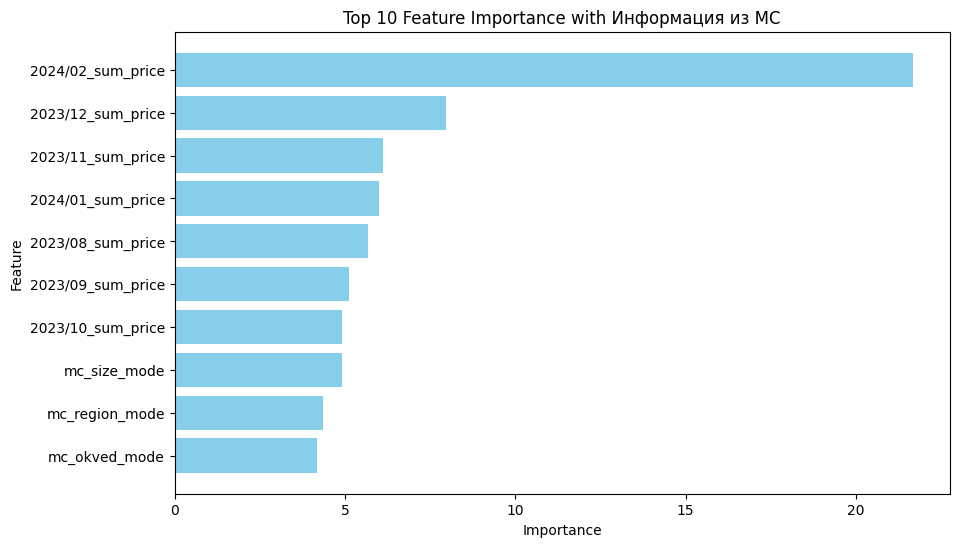

In [319]:
feature_selection(train_df = train, test_df = test, features = ['mc_count', 'mc_msp_mode', 'mc_size_mode', 'mc_okved_mode',
       'mc_region_mode', 'mc_sender_mode', 'mc_receiver_mode'],
                  cat_features = ['mc_msp_mode', 'mc_size_mode', 'mc_okved_mode',
       'mc_region_mode', 'mc_sender_mode', 'mc_receiver_mode'],
                  name = 'Информация из МС')

In [320]:
df_metrics

,Feature,acc,f1,roc_auc,log_loss
0,Базовые признаки,0.802083,0.746667,0.867612,0.408546
1,Полные данные об объемах,0.799479,0.725979,0.884029,0.398413
2,Информация о деталях поставок,0.817708,0.753521,0.899746,0.372693
3,Информация об обращениях пользователя,0.802083,0.744966,0.878572,0.397992
4,Информация об интересе,0.796875,0.741722,0.875201,0.397651
5,Информация из МС,0.802083,0.751634,0.865890,0.404053


Итог

In [332]:
import plotly.express as px
px.histogram(df_metrics, x='Feature', y='roc_auc', template = 'simple_white', title = 'ROC AUC для модели с разными признаками')

# Обучаем лучшую модель и получаем разметку

Аналогично первым обучениям с лучшими признаками обучим новую модель

In [327]:
unique_ids = pd.Series(df_train1['ID'].unique())

# Разбиваем на трейн и тест
train_ids, test_ids = train_test_split(unique_ids, test_size=0.1, random_state=228)

test_df1 = df_train1[df_train1['ID'].isin(test_ids)]
test_df2 = df_train2[df_train2['ID'].isin(test_ids)]

# Объединяем тестовые данные
test = pd.concat([test_df1, test_df2], ignore_index=True)

# Получаем тренировочные данные
train_df1 = df_train1[df_train1['ID'].isin(train_ids)]
train_df2 = df_train2[df_train2['ID'].isin(train_ids)]


# Объединяем тренировочные данные
train = pd.concat([train_df1, train_df2], ignore_index=True)


train[list(set(train.columns) - set(cat_features))] = train[list(set(train.columns) - set(cat_features))].astype(float)
train[cat_features] = train[cat_features].astype(str)
test[list(set(test.columns) - set(cat_features))] = test[list(set(test.columns) - set(cat_features))].astype(float)
test[cat_features] = test[cat_features].astype(str)

X_train = train.drop(columns=['ID', 'target1'])  # исключаем ID и target
y_train = train['target1']

X_test = test.drop(columns=['ID', 'target1'])  # исключаем ID и target
y_test = test['target1']

Accuracy: 0.8385
F1 Score: 0.7634
ROC-AUC: 0.9144
Log Loss: 0.3318


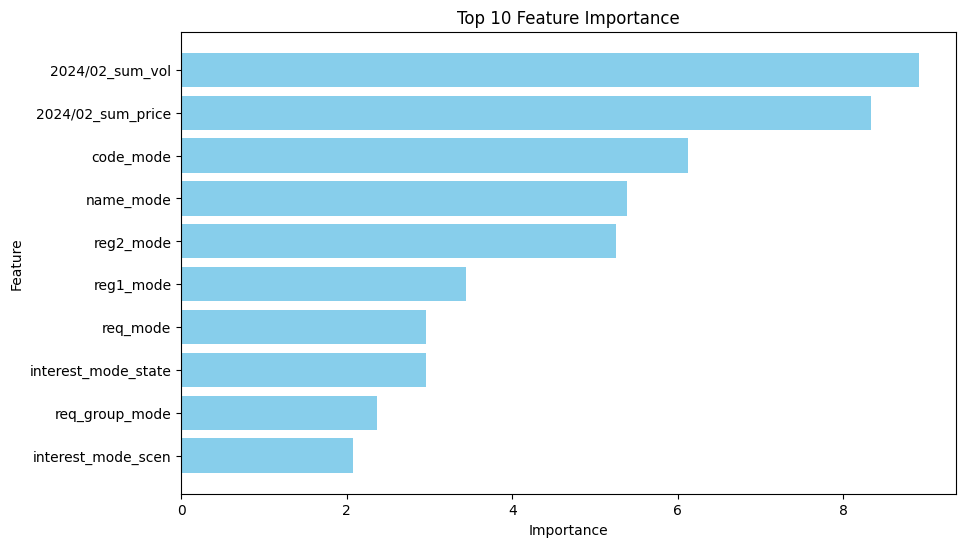

In [330]:
from sklearn.metrics import f1_score


model = CatBoostClassifier(cat_features=cat_features,
                           verbose=0)
model.fit(X_train, y_train)

# Предсказание и оценка точности на тестовой выборке
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # 'binary' для бинарной классификации, 'macro' или 'weighted' для многоклассовой

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

from sklearn.metrics import roc_auc_score, log_loss

# Получение вероятностей для тестовой выборки
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятность класса 1

# Рассчитываем ROC-AUC и log loss
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_value = log_loss(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")

# Получение важности признаков
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Сортировка по важности признаков
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Вывод таблицы с топ-10 важностью признаков
top_features = feature_importance_df.head(10)

# Визуализация важности топ-10 признаков
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Чтобы наиболее важные признаки были сверху
plt.show()
df_metrics = pd.concat([df_metrics, pd.DataFrame({'Feature': 'Итоговая модель', 'acc': accuracy, 'f1': f1, 'roc_auc': roc_auc, 'log_loss': log_loss_value}, index=[0])], ignore_index=True)


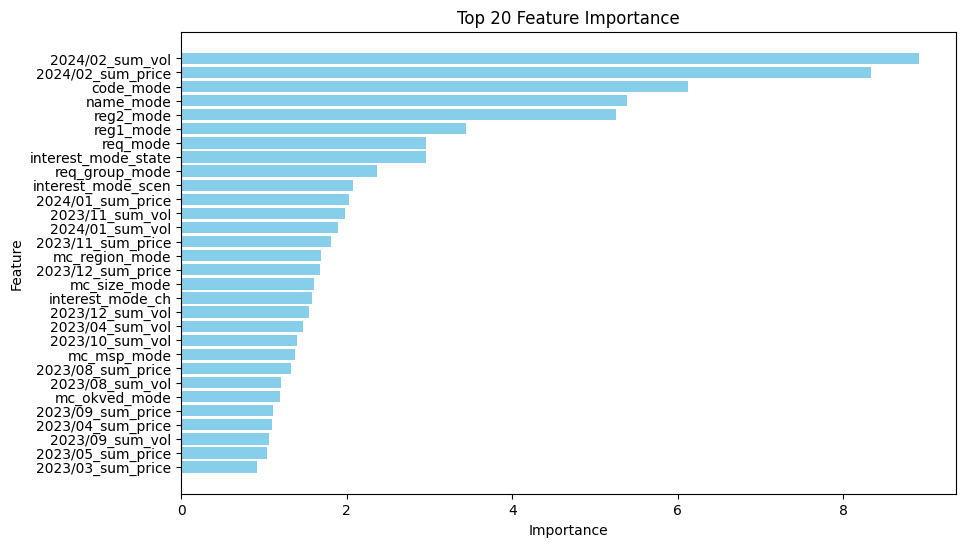

In [391]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Сортировка по важности признаков
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Вывод таблицы с топ-10 важностью признаков
top_features = feature_importance_df.head(30)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Чтобы наиболее важные признаки были сверху
plt.show()

In [331]:
df_metrics

,Feature,acc,f1,roc_auc,log_loss
0,Базовые признаки,0.802083,0.746667,0.867612,0.408546
1,Полные данные об объемах,0.799479,0.725979,0.884029,0.398413
2,Информация о деталях поставок,0.817708,0.753521,0.899746,0.372693
3,Информация об обращениях пользователя,0.802083,0.744966,0.878572,0.397992
4,Информация об интересе,0.796875,0.741722,0.875201,0.397651
5,Информация из МС,0.802083,0.751634,0.865890,0.404053
6,Итоговая модель,0.838542,0.763359,0.914394,0.331778


# Получаем предикт на текущий момент и анализируем его

In [350]:
df3[list(set(df3.columns) - set(cat_features))] = df3[list(set(df3.columns) - set(cat_features))].astype(float)
df3[cat_features] = df3[cat_features].astype(str)
pred_real = pd.DataFrame()
pred_real['ID'] = df3['ID']
pred_real['Регион'] = df3['reg1_mode']
pred_real['Вероятность'] = model.predict_proba(df3.drop(columns = 'ID'))[:, 1]
pred_real['ID'] = pred_real['ID'].astype(int).astype(str)

pred_real

,ID,Регион,Вероятность
0,9,Владимирская область,0.206016
1,25,Владимирская область,0.004060
2,33,Владимирская область,0.002773
4,115,Владимирская область,0.002216
5,144,Владимирская область,0.465558
...,...,...,...
951,21725,Владимирская область,0.631115
952,21726,Владимирская область,0.706161
953,21727,Чувашская Республика-Чаваш Республики,0.645110
954,21728,Удмуртская Республика,0.445755


Предикт получен

In [351]:
pred_real.to_csv('final_for_streamlit.csv')

In [347]:
pred_real['reg1_mode'] = df3['reg1_mode']

In [344]:
pred_real.to_csv('for_streamlit_v2.csv')

In [349]:
pred_real.head(20)

,ID,mc_region_mode,prob,reg1_mode
0,9,Владимирская область,0.206016,Владимирская область
1,25,Владимирская область,0.004060,Владимирская область
2,33,Владимирская область,0.002773,Владимирская область
4,115,Владимирская область,0.002216,Владимирская область
5,144,Владимирская область,0.465558,Владимирская область
6,247,Республика Татарстан,0.030032,Республика Татарстан (Татарстан)
10,424,Владимирская область,0.001299,Владимирская область
12,464,Владимирская область,0.105187,Владимирская область
13,478,Владимирская область,0.007870,Нижегородская область
14,479,Владимирская область,0.002325,Владимирская область


Посмотрим и исследуем взаимосвязи между выдаваемой вероятностью и разными признаками

In [356]:
px.histogram(pred_real[pred_real['Регион'] != 'unknown'], x = 'Вероятность', color = 'Регион', template = 'simple_white', title = 'Отток по регионам', nbins = 10,
             labels = {'prob':'вероятность оттока', 'count':'число клиентов'})

In [364]:
px.histogram(x = pred_real['Вероятность'], color = df3['name_mode'], template = 'simple_white',
             title = 'Распределение вероятностей по типу доставляемого товара', nbins = 10)

In [376]:
px.box(x = pred_real['Вероятность'], color = df3['req_mode'], template = 'simple_white',
             title = 'Распределение вероятностей по типу самых частых обращений', labels = {'prob':'вероятность оттока', 'count':'число клиентов'})

In [374]:
px.box(x = pred_real['Вероятность'], color = df3['interest_mode_state'], template = 'simple_white',
             title = 'Распределение вероятностей по типу самых частых итогов взаимодействий')

In [390]:
px.box(x = pred_real['Вероятность'], color = df3['interest_mode_ch'], template = 'simple_white',
             title = 'Распределение вероятностей по типу самых частых каналов взаимодействий')

In [377]:
px.box(x = pred_real['Вероятность'], color = df3['interest_mode_scen'], template = 'simple_white',
             title = 'Распределение вероятностей по типу самых частых сценариев взаимодействий', labels = {'prob':'вероятность оттока', 'count':'число клиентов'})

Сделаем функцию определения возможных интервалов ухода клиента

In [382]:
import pandas as pd

def define_churn_period(probability):
    """Функция для определения срока ухода пользователя на основе вероятности."""
    if probability < 0.4:
        return "скорее всего не уйдет"
    elif 0.4 <= probability < 0.5:
        return "6 месяцев"
    elif 0.5 <= probability < 0.6:
        return "3 месяца"
    elif 0.6 <= probability < 0.7:
        return "2 месяца"
    else:
        return "1 месяц"

# Пример применения функции к DataFrame
pred_real['через сколько вероятнее уйдет'] = pred_real['Вероятность'].apply(define_churn_period)


In [386]:
pred_real.to_csv('probabilities.csv')

In [ ]:
# Напишем функцию для инференса модели:
def model_inference(input_data):
    """Функция для инференса модели на новых данных."""
    input_data[list(set(input_data.columns) - set(cat_features))] = input_data[list(set(input_data.columns) - set(cat_features))].astype(float)
    input_data[cat_features] = input_data[cat_features].astype(str)
    predictions = model.predict_proba(input_data.drop(columns='ID'))[:, 1]
    return predictions